## 참고 :  https://velog.io/@vector13/Food101-데이터셋을-이용한-음식-이미지-분류기-만들기

### 0. 기본 환경 설정 

In [28]:
from shutil import copy
from collections import defaultdict
import scipy
import numpy as np
import matplotlib.pyplot as plt

import random
import cv2
import glob
from PIL import Image, ImageEnhance
import PIL.ImageOps

import torch
import torchvision
from torch import nn


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Theano(th)와 Tensorflow(tf) 모두와 호환이 되는 Keras 모듈을 작성
import keras.backend as K
from keras import regularizers
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator # 데이터 전처리
from keras.callbacks import ModelCheckpoint, CSVLogger
#from keras.optimizers import SGD

from keras_preprocessing.image import array_to_img, img_to_array, load_img

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())


2.6.0
/device:GPU:0


### 1. food101 train/test 나누기 (한번만 실행하기)
-[참고 자료](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)

In [42]:
def prepare_data(filepath, src,dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')
    food_list=list(classes_images.keys())[0:30]
    
    for food in food_list:
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!",food_list)

# 본인 환경에 맞게 food101 들어있는 디렉토리 설정하기
prepare_data('/data/home/ppleeqq/food-101/meta/train.txt', '/data/home/ppleeqq/food-101/images', '/data/home/ppleeqq/food-101/train')
prepare_data('/data/home/ppleeqq/food-101/meta/test.txt', '/data/home/ppleeqq/food-101/images', '/data/home/ppleeqq/food-101/test')  

Copying Done! ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes']
Copying Done! ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes']


### 2. Data augmentation (한번만 실행하기)
- 이미지 반전하는 함수와 이미지로 표현.
- [참고한 블로그1](https://wiserloner.tistory.com/1049)
- [augmented data 저장 방법](https://hipolarbear.tistory.com/19)

In [30]:
file_train_path = "/data/home/ppleeqq/food-101/train/"
file_test_path = "/data/home/ppleeqq/food-101/test/"

food_list = os.listdir(file_train_path)

for i in range(len(food_list)):
    file_path = file_train_path + food_list[i] + '/'
    x = os.listdir(file_path)
    file_names=[]
    for fn in x:
        if '.jpg' not in fn:
            continue
        else:
            file_names.append(fn)

    for j in range(0, len(file_names)):
        file_name = file_names[j]
        origin_image_path = file_path +  file_name
        x = Image.open(origin_image_path)

        x = img_to_array(x)
        x = x/255 
        
        if x.shape[2]!=1:
            grayscaled = tf.image.rgb_to_grayscale(x)
            saturated = tf.image.adjust_saturation(x, 3)
            bright = ImageEnhance.Brightness(array_to_img(x)).enhance(2.0)
        else:
            grayscaled = x
            saturated = x
            bright = x

        array_to_img(grayscaled).save(file_path + 'gray_' + file_name)
        array_to_img(saturated).save(file_path + 'saturated_' + file_name)
        array_to_img(bright).save(file_path + 'bright_' + file_name)
    print(i+1, end = ' ')

print("train done!")
        
for i in range(len(food_list)):
    file_path = file_test_path + food_list[i] + '/'
    x = os.listdir(file_path)
    file_names=[]
    for fn in x:
        if '.jpg' not in fn:
            continue
        else:
            file_names.append(fn)

    for j in range(0, len(file_names)):
        file_name = file_names[j]
        origin_image_path = file_path +  file_name
        x = Image.open(origin_image_path)

        x = img_to_array(x)
        x = x/255 
        
        # 흑백 사진은 오류가 떠서 그냥 사진 복제만 함 망할 베트맨 시키
        if x.shape[2]!=1:
            grayscaled = tf.image.rgb_to_grayscale(x)
            saturated = tf.image.adjust_saturation(x, 3)
            bright = ImageEnhance.Brightness(array_to_img(x)).enhance(2.0)
        else:
            grayscaled = x
            saturated = x
            bright = x

        array_to_img(grayscaled).save(file_path + 'gray_' + file_name)
        array_to_img(saturated).save(file_path + 'saturated_' + file_name)
        array_to_img(bright).save(file_path + 'bright_' + file_name)
    print(i+1, end = ' ')
        
print("test done!")

1 2 

KeyboardInterrupt: 

### 3. food101 데이터 기본 세팅 (전처리)

In [43]:
# releases the global state: avoid clutter from old models and layers
K.clear_session()

In [44]:
# 초기 변수 설정
n_classes = 30

### 이미지 크기 설정
img_width, img_height = 256,256


train_data_dir = '/data/home/ppleeqq/food-101/train'
validation_data_dir = '/data/home/ppleeqq/food-101/test'
nb_train_samples = 750*30       # 3000 * 101
nb_validation_samples = 250*30  # 1000 * 101
batch_size = 1                # 한 번 실행될 때 생성할 이미지 수

In [45]:
# ImageDataGenerator 객체 생성 (이미지 파일들을 Numpy Array 형태로 가져온 후 증강 기법 적용 준비)
train_datagen = ImageDataGenerator(
    rescale=1./ 255,       # multiply the data by the value
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,        # Shear angle in counter-clockwise direction as radians
    zoom_range=0.2,         # Range for random zoom. If a float
    horizontal_flip=True,   # Randomly flip inputs horizontally
    fill_mode='nearest')   


test_datagen = ImageDataGenerator(rescale=1./ 255)

In [46]:
# flow_from_directory : Numpy Array Iterator 객체 생성
# 인자로 설정해주는 directory의 바로 하위 디렉토리 이름을 레이블이라고 간주, 그 디렉토리 아래의 파일들을 해당 레이블의 이미지들이라고 알아서 추측


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse')
    #'categorical' : 멀티-레이블 클래스, 원-핫 인코딩된 형태
    #'sparse' : 멀티-레이블 클래스, 레이블 인코딩된 형태
    #'binary' : 이진 분류 클래스, 0 또는 1인 형태
    
    
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse')

Found 22500 images belonging to 30 classes.
Found 7500 images belonging to 30 classes.


### ImageDataGenerator 시각화

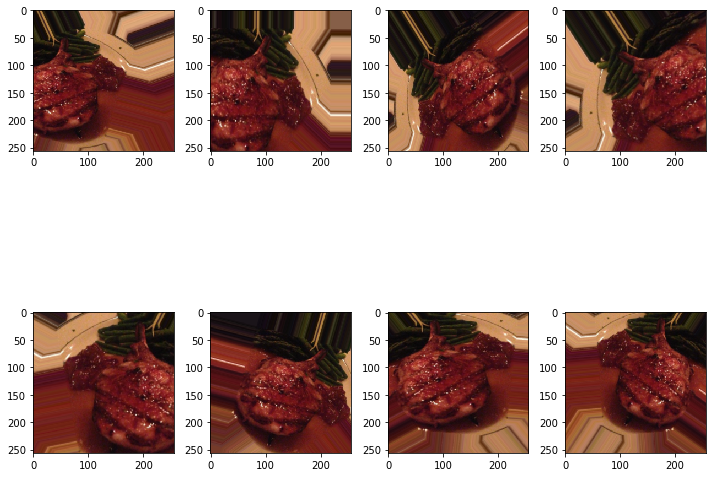

In [74]:
img, label = train_generator[0]
x = img[0]
x = x.reshape((1,) + x.shape) 

idx = 0
fig = plt.figure(figsize=(10, 10))
axs = []
for batch in train_datagen.flow(x, batch_size=1): # 여기서 batch는 x가 됨
    axs.append(fig.add_subplot(2, 4, idx+1))
    axs[idx].imshow(array_to_img(batch[0]))
    idx += 1
    if idx%8 == 0:
        break
fig.tight_layout()
plt.show()

### augmentation 시각화

TypeError: Invalid shape (512, 382, 1) for image data

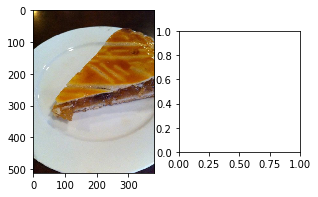

In [ ]:
file_path = "/data/home/ppleeqq/food-101/train/apple_pie/"
x = os.listdir(file_path)
file_names=[]
for fn in x:
    if '.jpg' not in fn:
        continue
    else:
        file_names.append(fn)

for i in range(1):
    file_name = file_names[i]
    origin_image_path = file_path +  file_name
    x = Image.open(origin_image_path)

    x = img_to_array(x)
    x = x/255 

    grayscaled = tf.image.rgb_to_grayscale(x)
    saturated = tf.image.adjust_saturation(x, 3)
    bright = ImageEnhance.Brightness(array_to_img(x)).enhance(2.0)


    fig=plt.figure(figsize=(10,10))

    fig.add_subplot(141).imshow(x)
    fig.add_subplot(142).imshow(grayscaled)
    fig.add_subplot(143).imshow(saturated)
    fig.add_subplot(144).imshow(bright)

    plt.show()



In [24]:
os.getcwd()

'/home/ppleeqq/dl_snu'

In [47]:
from deeplab2.model.pixel_encoder import moat
import tensorflow as tf
import numpy as np


### 우리가 어떤 인풋 사이즈로 하기로 했는지 잘 기억이 안남.
get_model(name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[요기조절하면 됨])

# 모델1 (바틀넥)

In [48]:
moat1=moat.get_model(
    name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[256,256,3])

In [49]:
moat1 = moat._load_moat_pretrained_checkpoint(moat1, path="./model-ckpt-0")

In [50]:
from tensorflow.keras.layers import (Input, Dense, concatenate, Conv2D, MaxPooling2D, Flatten)
from tensorflow import keras

moat1.input_shape
moat1.output_shape

{'stage1': (None, 128, 128, 32),
 'res1': (None, 128, 128, 32),
 'stage2': (None, 64, 64, 32),
 'res2': (None, 64, 64, 32),
 'stage3': (None, 32, 32, 64),
 'res3': (None, 32, 32, 64),
 'stage4': (None, 16, 16, 128),
 'res4': (None, 16, 16, 128),
 'stage5': (None, 8, 8, 256),
 'res5': (None, 8, 8, 256)}

In [51]:
y11 = moat1.output["stage1"]
y12 = moat1.output["res1"]
y21 = moat1.output["stage2"]
y22 = moat1.output["res2"]
y31 = moat1.output["stage3"]
y32 = moat1.output["res3"]
y41 = moat1.output["stage4"]
y42 = moat1.output["res4"]
y51 = moat1.output["stage5"]
y52 = moat1.output["res5"]

z1 = y11+y12
z2 = y21+y22
z3 = y31+y32
z4 = y41+y42
z5 = y51+y52

In [52]:
a1=Conv2D(8,(1,1),activation='relu')(z1)
a2=Conv2D(8,(3,3),activation='relu')(a1)
a3=MaxPooling2D(2,2)(a2) 
a4=Conv2D(8,(3,3),activation='relu')(a3)
a5=MaxPooling2D(2,2)(a4) 
a6=Conv2D(8,(3,3),activation='relu')(a5)
a7=MaxPooling2D(2,2)(a6) 
a8=Conv2D(8,(3,3),activation='relu')(a7)
a9=MaxPooling2D(2,2)(a8)
a10=Conv2D(8,(3,3),activation='relu')(a9)
a11=MaxPooling2D(2,2)(a10)
a12=Conv2D(32,(1,1),activation='relu')(a11)
aa1=Flatten(name='flatten_layer1')(a12)

b1=Conv2D(8,(1,1),activation='relu')(z2)
b2=Conv2D(8,(3,3),activation='relu')(b1)
b3=MaxPooling2D(2,2)(b2) 
b4=Conv2D(8,(3,3),activation='relu')(b3)
b5=MaxPooling2D(2,2)(b4) 
b6=Conv2D(8,(3,3),activation='relu')(b5)
b7=MaxPooling2D(2,2)(b6) 
b8=Conv2D(8,(3,3),activation='relu')(b7)
b9=MaxPooling2D(2,2)(b8)
b10=Conv2D(32,(1,1),activation='relu')(b9)
bb1=Flatten(name='flatten_layer2')(b10)

c1=Conv2D(16,(1,1),activation='relu')(z3)
c2=Conv2D(16,(3,3),activation='relu')(c1)
c3=MaxPooling2D(2,2)(c2) 
c4=Conv2D(16,(3,3),activation='relu')(c3)
c5=MaxPooling2D(2,2)(c4) 
c6=Conv2D(16,(3,3),activation='relu')(c5)
c7=MaxPooling2D(2,2)(c6) 
c8=Conv2D(64,(1,1),activation='relu')(c7)
cc1=Flatten(name='flatten_layer3')(c8)

d1=Conv2D(32,(1,1),activation='relu')(z4)
d2=Conv2D(32,(3,3),activation='relu')(d1)
d3=MaxPooling2D(2,2)(d2) 
d4=Conv2D(32,(3,3),activation='relu')(d3)
d5=MaxPooling2D(2,2)(d4) 
d6=Conv2D(128,(1,1),activation='relu')(d5)
dd1=Flatten(name='flatten_layer4')(d6)

e1=Conv2D(64,(1,1),activation='relu')(z5)
e2=Conv2D(64,(3,3),activation='relu')(e1)
e3=MaxPooling2D(2,2)(e2) 
e4=Conv2D(64,(2,2),activation='relu')(e3)
e5=Conv2D(256,(1,1),activation='relu')(e4)
ee1=Flatten(name='flatten_layer5')(e5)

fc1=tf.concat([aa1,bb1,cc1,dd1,ee1],axis=1)
out1=Dense(units=101, activation='softmax')(fc1)

model1 = tf.keras.models.Model(moat1.input, out1)
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
checkpointer = ModelCheckpoint(filepath='best_model_3class_sept.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

history = model1.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,      #  한 epoch에 사용한 스텝 수
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,  # 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수
                    epochs=5,                                             # 전체 훈련 데이터셋에 대해 학습 반복 횟수
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained.h5')

Epoch 1/5
22500/22500 [==============================] - 2651s 117ms/step - loss: 3.4262 - accuracy: 0.0323 - val_loss: 3.4020 - val_accuracy: 0.0333

Epoch 00001: val_loss improved from inf to 3.40203, saving model to best_model_3class_sept.hdf5


NotImplementedError: 

### 우리가 어떤 인풋 사이즈로 하기로 했는지 잘 기억이 안남.
get_model(name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[요기조절하면 됨])

# 모델1 (바틀넥)

In [330]:
moat1=moat.get_model(
    name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[128,128,3])

In [331]:
moat1 = moat._load_moat_pretrained_checkpoint(moat1, path="./model-ckpt-0")

In [332]:
from tensorflow.keras.layers import (Input, Dense, concatenate, Conv2D, MaxPooling2D, Flatten)
from tensorflow import keras

moat1.input_shape
moat1.output_shape

{'stage1': (None, 128, 128, 32),
 'res1': (None, 128, 128, 32),
 'stage2': (None, 64, 64, 32),
 'res2': (None, 64, 64, 32),
 'stage3': (None, 32, 32, 64),
 'res3': (None, 32, 32, 64),
 'stage4': (None, 16, 16, 128),
 'res4': (None, 16, 16, 128),
 'stage5': (None, 8, 8, 256),
 'res5': (None, 8, 8, 256)}

In [333]:
y11 = moat1.output["stage1"]
y12 = moat1.output["res1"]
y21 = moat1.output["stage2"]
y22 = moat1.output["res2"]
y31 = moat1.output["stage3"]
y32 = moat1.output["res3"]
y41 = moat1.output["stage4"]
y42 = moat1.output["res4"]
y51 = moat1.output["stage5"]
y52 = moat1.output["res5"]

z1 = y11+y12
z2 = y21+y22
z3 = y31+y32
z4 = y41+y42
z5 = y51+y52

In [334]:
a1=Conv2D(8,(1,1),activation='relu')(z1)
a2=Conv2D(8,(3,3),activation='relu')(a1)
a3=MaxPooling2D(2,2)(a2) 
a4=Conv2D(8,(3,3),activation='relu')(a3)
a5=MaxPooling2D(2,2)(a4) 
a6=Conv2D(8,(3,3),activation='relu')(a5)
a7=MaxPooling2D(2,2)(a6) 
a8=Conv2D(8,(3,3),activation='relu')(a7)
a9=MaxPooling2D(2,2)(a8)
a10=Conv2D(8,(3,3),activation='relu')(a9)
a11=MaxPooling2D(2,2)(a10)
a12=Conv2D(32,(1,1),activation='relu')(a11)
aa1=Flatten(name='flatten_layer1')(a12)

b1=Conv2D(8,(1,1),activation='relu')(z2)
b2=Conv2D(8,(3,3),activation='relu')(b1)
b3=MaxPooling2D(2,2)(b2) 
b4=Conv2D(8,(3,3),activation='relu')(b3)
b5=MaxPooling2D(2,2)(b4) 
b6=Conv2D(8,(3,3),activation='relu')(b5)
b7=MaxPooling2D(2,2)(b6) 
b8=Conv2D(8,(3,3),activation='relu')(b7)
b9=MaxPooling2D(2,2)(b8)
b10=Conv2D(32,(1,1),activation='relu')(b9)
bb1=Flatten(name='flatten_layer2')(b10)

c1=Conv2D(16,(1,1),activation='relu')(z3)
c2=Conv2D(16,(3,3),activation='relu')(c1)
c3=MaxPooling2D(2,2)(c2) 
c4=Conv2D(16,(3,3),activation='relu')(c3)
c5=MaxPooling2D(2,2)(c4) 
c6=Conv2D(16,(3,3),activation='relu')(c5)
c7=MaxPooling2D(2,2)(c6) 
c8=Conv2D(64,(1,1),activation='relu')(c7)
cc1=Flatten(name='flatten_layer3')(c8)

d1=Conv2D(32,(1,1),activation='relu')(z4)
d2=Conv2D(32,(3,3),activation='relu')(d1)
d3=MaxPooling2D(2,2)(d2) 
d4=Conv2D(32,(3,3),activation='relu')(d3)
d5=MaxPooling2D(2,2)(d4) 
d6=Conv2D(128,(1,1),activation='relu')(d5)
dd1=Flatten(name='flatten_layer4')(d6)

e1=Conv2D(64,(1,1),activation='relu')(z5)
e2=Conv2D(64,(3,3),activation='relu')(e1)
e3=MaxPooling2D(2,2)(e2) 
e4=Conv2D(64,(2,2),activation='relu')(e3)
e5=Conv2D(256,(1,1),activation='relu')(e4)
ee1=Flatten(name='flatten_layer5')(e5)

fc1=tf.concat([aa1,bb1,cc1,dd1,ee1],axis=1)
out1=Dense(units=101, activation='softmax')(fc1)

model1 = tf.keras.models.Model(moat1.input, out1)
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 2

In [335]:
moat2=moat.get_model(
    name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[256,256,3])

In [336]:
moat2 = moat._load_moat_pretrained_checkpoint(moat2, path="./model-ckpt-0")

In [337]:
k11 = moat2.output["stage1"]
k12 = moat2.output["res1"]
k21 = moat2.output["stage2"]
k22 = moat2.output["res2"]
k31 = moat2.output["stage3"]
k32 = moat2.output["res3"]
k41 = moat2.output["stage4"]
k42 = moat2.output["res4"]
k51 = moat2.output["stage5"]
k52 = moat2.output["res5"]

l1 = k11+k12
l2 = k21+k22
l3 = k31+k32
l4 = k41+k42
l5 = k51+k52

In [338]:
f1=Conv2D(32,(3,3),activation='relu')(l1)
f2=MaxPooling2D(2,2)(f1) 
f3=Conv2D(40,(3,3),activation='relu')(f2)
f4=MaxPooling2D(2,2)(f3) 
f5=Conv2D(48,(3,3),activation='relu')(f4)
f6=MaxPooling2D(2,2)(f5) 
f7=Conv2D(56,(3,3),activation='relu')(f6)
f8=MaxPooling2D(2,2)(f7)
f9=Conv2D(64,(3,3),activation='relu')(f8)
f10=MaxPooling2D(2,2)(f9)
f11=Conv2D(72,(2,2),activation='relu')(f10)
ff1=Flatten(name='flatten_layer1')(f11)

g1=Conv2D(32,(3,3),activation='relu')(l2)
g2=MaxPooling2D(2,2)(g1) 
g3=Conv2D(40,(3,3),activation='relu')(g2)
g4=MaxPooling2D(2,2)(g3) 
g5=Conv2D(48,(3,3),activation='relu')(g4)
g6=MaxPooling2D(2,2)(g5) 
g7=Conv2D(56,(3,3),activation='relu')(g6)
g8=MaxPooling2D(2,2)(g7)
g9=Conv2D(64,(2,2),activation='relu')(g8)
gg1=Flatten(name='flatten_layer2')(g9)

h1=Conv2D(64,(3,3),activation='relu')(l3)
h2=MaxPooling2D(2,2)(h1) 
h3=Conv2D(80,(3,3),activation='relu')(h2)
h4=MaxPooling2D(2,2)(h3) 
h5=Conv2D(96,(3,3),activation='relu')(h4)
h6=MaxPooling2D(2,2)(h5) 
h7=Conv2D(112,(2,2),activation='relu')(h6)
hh1=Flatten(name='flatten_layer3')(h7)

i1=Conv2D(128,(3,3),activation='relu')(l4)
i2=MaxPooling2D(2,2)(i1) 
i3=Conv2D(160,(3,3),activation='relu')(i2)
i4=MaxPooling2D(2,2)(i3) 
i5=Conv2D(200,(2,2),activation='relu')(i4)
ii1=Flatten(name='flatten_layer4')(i5)

j1=Conv2D(256,(3,3),activation='relu')(l5)
j2=MaxPooling2D(2,2)(j1) 
j3=Conv2D(320,(3,3),activation='relu')(j2)
jj1=Flatten(name='flatten_layer5')(j3)

fc2=tf.concat([ff1,gg1,hh1,ii1,jj1],axis=1)
out2=Dense(units=101, activation='softmax')(fc2)

model2 = tf.keras.models.Model(moat2.input, out2)
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


### 우리가 어떤 인풋 사이즈로 하기로 했는지 잘 기억이 안남.
get_model(name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[요기조절하면 됨])

# 모델1 (바틀넥)

In [330]:
moat1=moat.get_model(
    name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[256,256,3])

In [331]:
moat1 = moat._load_moat_pretrained_checkpoint(moat1, path="./model-ckpt-0")

In [332]:
from tensorflow.keras.layers import (Input, Dense, concatenate, Conv2D, MaxPooling2D, Flatten)
from tensorflow import keras

moat1.input_shape
moat1.output_shape

{'stage1': (None, 128, 128, 32),
 'res1': (None, 128, 128, 32),
 'stage2': (None, 64, 64, 32),
 'res2': (None, 64, 64, 32),
 'stage3': (None, 32, 32, 64),
 'res3': (None, 32, 32, 64),
 'stage4': (None, 16, 16, 128),
 'res4': (None, 16, 16, 128),
 'stage5': (None, 8, 8, 256),
 'res5': (None, 8, 8, 256)}

In [333]:
y11 = moat1.output["stage1"]
y12 = moat1.output["res1"]
y21 = moat1.output["stage2"]
y22 = moat1.output["res2"]
y31 = moat1.output["stage3"]
y32 = moat1.output["res3"]
y41 = moat1.output["stage4"]
y42 = moat1.output["res4"]
y51 = moat1.output["stage5"]
y52 = moat1.output["res5"]

z1 = y11+y12
z2 = y21+y22
z3 = y31+y32
z4 = y41+y42
z5 = y51+y52

In [334]:
a1=Conv2D(8,(1,1),activation='relu')(z1)
a2=Conv2D(8,(3,3),activation='relu')(a1)
a3=MaxPooling2D(2,2)(a2) 
a4=Conv2D(8,(3,3),activation='relu')(a3)
a5=MaxPooling2D(2,2)(a4) 
a6=Conv2D(8,(3,3),activation='relu')(a5)
a7=MaxPooling2D(2,2)(a6) 
a8=Conv2D(8,(3,3),activation='relu')(a7)
a9=MaxPooling2D(2,2)(a8)
a10=Conv2D(8,(3,3),activation='relu')(a9)
a11=MaxPooling2D(2,2)(a10)
a12=Conv2D(32,(1,1),activation='relu')(a11)
aa1=Flatten(name='flatten_layer1')(a12)

b1=Conv2D(8,(1,1),activation='relu')(z2)
b2=Conv2D(8,(3,3),activation='relu')(b1)
b3=MaxPooling2D(2,2)(b2) 
b4=Conv2D(8,(3,3),activation='relu')(b3)
b5=MaxPooling2D(2,2)(b4) 
b6=Conv2D(8,(3,3),activation='relu')(b5)
b7=MaxPooling2D(2,2)(b6) 
b8=Conv2D(8,(3,3),activation='relu')(b7)
b9=MaxPooling2D(2,2)(b8)
b10=Conv2D(32,(1,1),activation='relu')(b9)
bb1=Flatten(name='flatten_layer2')(b10)

c1=Conv2D(16,(1,1),activation='relu')(z3)
c2=Conv2D(16,(3,3),activation='relu')(c1)
c3=MaxPooling2D(2,2)(c2) 
c4=Conv2D(16,(3,3),activation='relu')(c3)
c5=MaxPooling2D(2,2)(c4) 
c6=Conv2D(16,(3,3),activation='relu')(c5)
c7=MaxPooling2D(2,2)(c6) 
c8=Conv2D(64,(1,1),activation='relu')(c7)
cc1=Flatten(name='flatten_layer3')(c8)

d1=Conv2D(32,(1,1),activation='relu')(z4)
d2=Conv2D(32,(3,3),activation='relu')(d1)
d3=MaxPooling2D(2,2)(d2) 
d4=Conv2D(32,(3,3),activation='relu')(d3)
d5=MaxPooling2D(2,2)(d4) 
d6=Conv2D(128,(1,1),activation='relu')(d5)
dd1=Flatten(name='flatten_layer4')(d6)

e1=Conv2D(64,(1,1),activation='relu')(z5)
e2=Conv2D(64,(3,3),activation='relu')(e1)
e3=MaxPooling2D(2,2)(e2) 
e4=Conv2D(64,(2,2),activation='relu')(e3)
e5=Conv2D(256,(1,1),activation='relu')(e4)
ee1=Flatten(name='flatten_layer5')(e5)

fc1=tf.concat([aa1,bb1,cc1,dd1,ee1],axis=1)
out1=Dense(units=101, activation='softmax')(fc1)

model1 = tf.keras.models.Model(moat1.input, out1)
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 2

In [335]:
moat2=moat.get_model(
    name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[256,256,3])

In [336]:
moat2 = moat._load_moat_pretrained_checkpoint(moat2, path="./model-ckpt-0")

In [337]:
k11 = moat2.output["stage1"]
k12 = moat2.output["res1"]
k21 = moat2.output["stage2"]
k22 = moat2.output["res2"]
k31 = moat2.output["stage3"]
k32 = moat2.output["res3"]
k41 = moat2.output["stage4"]
k42 = moat2.output["res4"]
k51 = moat2.output["stage5"]
k52 = moat2.output["res5"]

l1 = k11+k12
l2 = k21+k22
l3 = k31+k32
l4 = k41+k42
l5 = k51+k52

In [338]:
f1=Conv2D(32,(3,3),activation='relu')(l1)
f2=MaxPooling2D(2,2)(f1) 
f3=Conv2D(40,(3,3),activation='relu')(f2)
f4=MaxPooling2D(2,2)(f3) 
f5=Conv2D(48,(3,3),activation='relu')(f4)
f6=MaxPooling2D(2,2)(f5) 
f7=Conv2D(56,(3,3),activation='relu')(f6)
f8=MaxPooling2D(2,2)(f7)
f9=Conv2D(64,(3,3),activation='relu')(f8)
f10=MaxPooling2D(2,2)(f9)
f11=Conv2D(72,(2,2),activation='relu')(f10)
ff1=Flatten(name='flatten_layer1')(f11)

g1=Conv2D(32,(3,3),activation='relu')(l2)
g2=MaxPooling2D(2,2)(g1) 
g3=Conv2D(40,(3,3),activation='relu')(g2)
g4=MaxPooling2D(2,2)(g3) 
g5=Conv2D(48,(3,3),activation='relu')(g4)
g6=MaxPooling2D(2,2)(g5) 
g7=Conv2D(56,(3,3),activation='relu')(g6)
g8=MaxPooling2D(2,2)(g7)
g9=Conv2D(64,(2,2),activation='relu')(g8)
gg1=Flatten(name='flatten_layer2')(g9)

h1=Conv2D(64,(3,3),activation='relu')(l3)
h2=MaxPooling2D(2,2)(h1) 
h3=Conv2D(80,(3,3),activation='relu')(h2)
h4=MaxPooling2D(2,2)(h3) 
h5=Conv2D(96,(3,3),activation='relu')(h4)
h6=MaxPooling2D(2,2)(h5) 
h7=Conv2D(112,(2,2),activation='relu')(h6)
hh1=Flatten(name='flatten_layer3')(h7)

i1=Conv2D(128,(3,3),activation='relu')(l4)
i2=MaxPooling2D(2,2)(i1) 
i3=Conv2D(160,(3,3),activation='relu')(i2)
i4=MaxPooling2D(2,2)(i3) 
i5=Conv2D(200,(2,2),activation='relu')(i4)
ii1=Flatten(name='flatten_layer4')(i5)

j1=Conv2D(256,(3,3),activation='relu')(l5)
j2=MaxPooling2D(2,2)(j1) 
j3=Conv2D(320,(3,3),activation='relu')(j2)
jj1=Flatten(name='flatten_layer5')(j3)

fc2=tf.concat([ff1,gg1,hh1,ii1,jj1],axis=1)
out2=Dense(units=101, activation='softmax')(fc2)

model2 = tf.keras.models.Model(moat2.input, out2)
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# 모델 2

In [ ]:
moat2=moat.get_model(
    name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[256,256,3])

In [ ]:
moat2 = moat._load_moat_pretrained_checkpoint(moat2, path="./model-ckpt-0")

In [ ]:
k11 = moat2.output["stage1"]
k12 = moat2.output["res1"]
k21 = moat2.output["stage2"]
k22 = moat2.output["res2"]
k31 = moat2.output["stage3"]
k32 = moat2.output["res3"]
k41 = moat2.output["stage4"]
k42 = moat2.output["res4"]
k51 = moat2.output["stage5"]
k52 = moat2.output["res5"]

l1 = k11+k12
l2 = k21+k22
l3 = k31+k32
l4 = k41+k42
l5 = k51+k52

In [ ]:
f1=Conv2D(32,(3,3),activation='relu')(l1)
f2=MaxPooling2D(2,2)(f1) 
f3=Conv2D(40,(3,3),activation='relu')(f2)
f4=MaxPooling2D(2,2)(f3) 
f5=Conv2D(48,(3,3),activation='relu')(f4)
f6=MaxPooling2D(2,2)(f5) 
f7=Conv2D(56,(3,3),activation='relu')(f6)
f8=MaxPooling2D(2,2)(f7)
f9=Conv2D(64,(3,3),activation='relu')(f8)
f10=MaxPooling2D(2,2)(f9)
f11=Conv2D(72,(2,2),activation='relu')(f10)
ff1=Flatten(name='flatten_layer1')(f11)

g1=Conv2D(32,(3,3),activation='relu')(l2)
g2=MaxPooling2D(2,2)(g1) 
g3=Conv2D(40,(3,3),activation='relu')(g2)
g4=MaxPooling2D(2,2)(g3) 
g5=Conv2D(48,(3,3),activation='relu')(g4)
g6=MaxPooling2D(2,2)(g5) 
g7=Conv2D(56,(3,3),activation='relu')(g6)
g8=MaxPooling2D(2,2)(g7)
g9=Conv2D(64,(2,2),activation='relu')(g8)
gg1=Flatten(name='flatten_layer2')(g9)

h1=Conv2D(64,(3,3),activation='relu')(l3)
h2=MaxPooling2D(2,2)(h1) 
h3=Conv2D(80,(3,3),activation='relu')(h2)
h4=MaxPooling2D(2,2)(h3) 
h5=Conv2D(96,(3,3),activation='relu')(h4)
h6=MaxPooling2D(2,2)(h5) 
h7=Conv2D(112,(2,2),activation='relu')(h6)
hh1=Flatten(name='flatten_layer3')(h7)

i1=Conv2D(128,(3,3),activation='relu')(l4)
i2=MaxPooling2D(2,2)(i1) 
i3=Conv2D(160,(3,3),activation='relu')(i2)
i4=MaxPooling2D(2,2)(i3) 
i5=Conv2D(200,(2,2),activation='relu')(i4)
ii1=Flatten(name='flatten_layer4')(i5)

j1=Conv2D(256,(3,3),activation='relu')(l5)
j2=MaxPooling2D(2,2)(j1) 
j3=Conv2D(320,(3,3),activation='relu')(j2)
jj1=Flatten(name='flatten_layer5')(j3)

fc2=tf.concat([ff1,gg1,hh1,ii1,jj1],axis=1)
out2=Dense(units=101, activation='softmax')(fc2)

model2 = tf.keras.models.Model(moat2.input, out2)
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
